In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
Base.classes.measurement.__table__

Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None)

In [9]:
Base.classes.station.__table__

Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
import datetime
from dateutil import relativedelta

#Get the max date from the table
max_date = datetime.datetime.strptime(session.query(func.max(Measurement.date)).all()[0][0], '%Y-%m-%d').date()
#get the date 12 months before
twelve_months_ago = (max_date - relativedelta.relativedelta(months=12)).strftime('%Y-%m-%d')

print(f"Max Date in Table: {max_date}, \nTwelve months ago: {twelve_months_ago}")

Max Date in Table: 2017-08-23, 
Twelve months ago: 2016-08-23


In [13]:
#Retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
query_tewlve_months = session.query(Measurement).filter(Measurement.date >= twelve_months_ago)
# Save the query results as a Pandas DataFrame 
df_Measurement = pd.read_sql(query_tewlve_months.statement, query_tewlve_months.session.bind)
# set the index to the date column 
df_Measurement.set_index('date', inplace=True)
# Sort the dataframe by date
df_Measurement.sort_index(inplace=True)
df_Measurement.rename(columns={"prcp": "precipitation"},inplace=True)
df_Measurement.head()

,id,station,precipitation,tobs
date,,,,
2016-08-23,2364,USC00519397,0.00,81.0
2016-08-23,8825,USC00517948,NaN,80.0
2016-08-23,14608,USC00519281,1.79,77.0
2016-08-23,7331,USC00514830,0.05,80.0
2016-08-23,5091,USC00513117,0.15,76.0


<IPython.core.display.Javascript object>


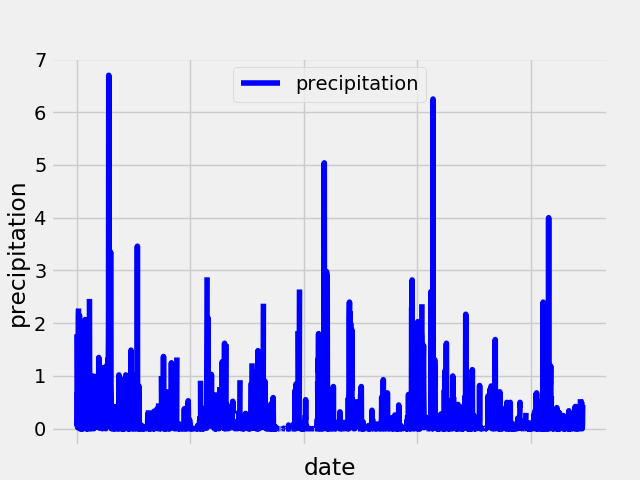

In [52]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df_Measurement['precipitation'].plot( color='blue')
ax.set_ylabel("precipitation")
ax.set_xlabel("date")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='best')


In [54]:
fig = ax.get_figure()
fig.savefig('./images/precipitation.png')

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pd.DataFrame(df_Measurement["precipitation"].describe())

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# How many stations are available in this dataset?
query = session.query( Measurement.station, func.count(Measurement.station) ).group_by(Measurement.station).all()
len(query)


9

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
query.sort(key=lambda tup: tup[1], reverse=True)
query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_station = query[0][0]
query_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                                     filter(Measurement.station == active_station)

query_active_station.all()


[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_Measurement.head()


,id,station,precipitation,tobs
date,,,,
2016-08-23,2364,USC00519397,0.00,81.0
2016-08-23,8825,USC00517948,NaN,80.0
2016-08-23,14608,USC00519281,1.79,77.0
2016-08-23,7331,USC00514830,0.05,80.0
2016-08-23,5091,USC00513117,0.15,76.0


In [20]:
query_all = session.query(Measurement)
# Save the query results as a Pandas DataFrame 
df_Measurement_all = pd.read_sql(query_all.statement, query_all.session.bind)
# set the index to the date column 
df_Measurement_all.set_index('date', inplace=True)
# Sort the dataframe by date
df_Measurement_all.sort_index(inplace=True)
df_Measurement_all.rename(columns={"prcp": "precipitation"},inplace=True)
df_Measurement_all.head()

,id,station,precipitation,tobs
date,,,,
2010-01-01,1,USC00519397,0.08,65.0
2010-01-01,9008,USC00518838,0.21,72.0
2010-01-01,9519,USC00519523,0.15,75.0
2010-01-01,12188,USC00519281,0.15,70.0
2010-01-01,14960,USC00511918,0.05,66.0


In [21]:
#all data
df_Measurement_all.groupby(['station']).count()['tobs'].sort_values(ascending = False)

station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: tobs, dtype: int64

In [22]:
# highest number of observations.
highest_observations = df_Measurement_all.groupby(['station']).count()['tobs'].sort_values(ascending = False).index[0]
print(highest_observations)
df_highest_observations = df_Measurement_all[(df_Measurement_all['station'] == highest_observations)]

USC00519281


In [23]:
df_highest_observations.head()

,id,station,precipitation,tobs
date,,,,
2010-01-01,12188,USC00519281,0.15,70.0
2010-01-02,12189,USC00519281,0.00,62.0
2010-01-03,12190,USC00519281,0.00,74.0
2010-01-04,12191,USC00519281,0.00,75.0
2010-01-05,12192,USC00519281,0.00,74.0


<IPython.core.display.Javascript object>


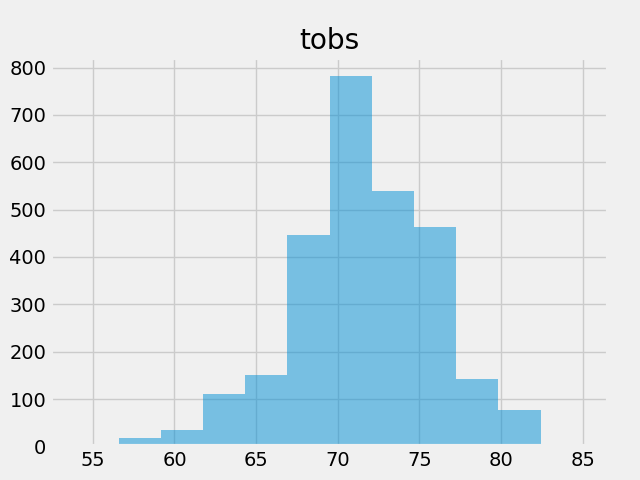

In [59]:
df_temp = pd.DataFrame(df_highest_observations["tobs"])
#df_temp

df_temp.hist(bins=12, alpha=0.5)
plt.savefig('./images/Temp.png')
plt.show()


In [25]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min_avg_max = calc_temps(twelve_months_ago, max_date)
min_avg_max


[(58.0, 74.59058295964125, 87.0)]

<IPython.core.display.Javascript object>


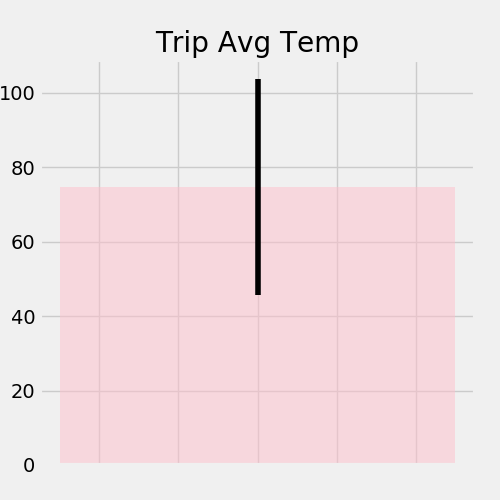

In [63]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df2 = pd.DataFrame(index=df_highest_observations["tobs"])

plt.figure(figsize = (5,5))
plt.bar([10], min_avg_max[0][1], yerr=(min_avg_max[0][0]-min_avg_max[0][2]), color='pink', alpha=0.5, width=0.1)
plt.tick_params(
     axis='x',          # changes apply to the x-axis
     which='both',      # both major and minor ticks are affected
     bottom=False,      # ticks along the bottom edge are off
     top=False,         # ticks along the top edge are off
     labelbottom=False)
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')

plt.savefig('./images/Avg.png')
plt.show()


In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [32]:
# Plot the daily normals as an area plot with `stacked=False`
